## 02 Stardist Training

The stardist model is used to create instance masks for a subsequent watershed. The main drawback of stardist is that one doesn't get accurate cell borders due to the limited number of polygons (depending on computational expenses). Therefore, this model 'only' operates with 32 angles. For details on how to install stardist, please check out their [Github](https://github.com/mpicbg-csbd/stardist).

In [1]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tqdm
import datetime
import skimage

import utils.dirtools
import utils.data_provider
import utils.augmentation
import stardist
from stardist.models import Config2D

lbl_cmap = stardist.random_label_cmap()

/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/beichenberger/anac

### Image import

Because Stardist doesn't allow for runtime reading of images, we have to import them here. The `stardist_importer` import the images and normalizes them for the network to use.

In [2]:
root = '/Users/beichenberger/Downloads/Training/Stardist_training/train_val'

In [3]:
# Import paths
X = sorted(glob.glob(f'{root}/images/*.tif'))
Y = sorted(glob.glob(f'{root}/masks/*.tif'))

In [4]:
# Train / valid split
x_train, x_valid, y_train, y_valid = utils.dirtools.train_valid_split(x_list=X, y_list=Y, valid_split=0.2)

# Import images – stardist doesnt allow for runtime reading
x_train, y_train = utils.data_provider.stardist_importer(x_train, y_train)
x_valid, y_valid = utils.data_provider.stardist_importer(x_valid, y_valid)

Total images: 753
– training images: 602
– validation images: 151


Masks: 100%|██████████| 151/151 [00:02<00:00, 63.33it/s]


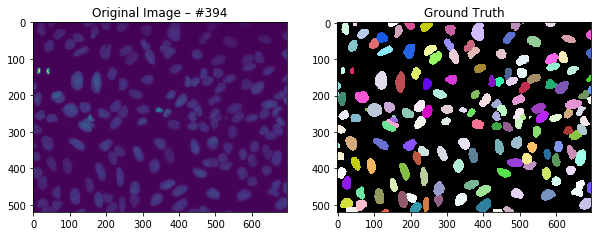

In [5]:
# Sanity check
ix = np.random.randint(0, len(X)-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(skimage.io.imread(X[ix]))
ax[0].set_title(f'Original Image – #{ix}')
ax[1].imshow(skimage.io.imread(Y[ix]), cmap=lbl_cmap)
ax[1].set_title('Ground Truth')
plt.show()

### Configure model

The hyperparameters and augmentations can be changed below. We decided on the number of rays as 32 due to stardists reccomendations as can be seen [here](https://nbviewer.jupyter.org/github/mpicbg-csbd/stardist/blob/master/examples/2D/1_data.ipynb). If the starnet model passes some more tests, one could probably decrease the number of rays to 16 or 8 as only the centroid location is actually used.

In [6]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [7]:
# Hyperparameters
conf = Config2D (
    train_epochs = 4, # 400,
    train_steps_per_epoch = 10, # 100,
    n_rays = 32,
    grid = (2, 2),
    use_gpu = False, #and gputools_available(),
    unet_n_depth = 3,
    n_channel_in = 1 if x_train[0].ndim==2 else x_train[0].shape[-1],
    train_patch_size = (256, 256),
)

# ImageDataGenerator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     zoom_range=0.5,
                     shear_range=0.5,
                     width_shift_range=0.5,
                     height_shift_range=0.5,
                     fill_mode='reflect',
                     data_format='channels_last')

#vars(conf)

In [8]:
model_name = f"{datetime.date.today().strftime('%Y%m%d')}_Star"
model = stardist.models.StarDist2D(conf, name=model_name, basedir='./models/')

/Users/beichenberger/anaconda3/envs/image/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /Users/beichenberger/Documents/Github/nuclear_segmentation/models/20191031_Star
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))



Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [9]:
# Check filed of view size
median_size = stardist.calculate_extents(list(y_train), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print('Median object size > FOV') if any(median_size > fov) else print('')

### Training

Connect to [http://localhost:6006/](http://localhost:6006/) after activating tensorboard.

    $ tensorboard --logdir=.


In [ ]:
model.train(x_train, y_train,
            validation_data=(x_valid, y_valid),
            augmenter=utils.augmentation.StarAugment(**data_gen_args).augment)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/4
10/10 [==============================] - 81s 8s/step - loss: 3.1874 - prob_loss: 0.6817 - dist_loss: 12.5286 - prob_kld: 0.6017 - dist_relevant_mae: 12.5286 - dist_relevant_mse: 506.8204 - val_loss: 4.1887 - val_prob_loss: 0.6092 - val_dist_loss: 17.8975 - val_prob_kld: 0.5149 - val_dist_relevant_mae: 17.8975 - val_dist_relevant_mse: 671.7228
Epoch 2/4
10/10 [==============================] - 61s 6s/step - loss: 2.8628 - prob_loss: 0.4747 - dist_loss: 11.9406 - prob_kld: 0.3910 - dist_relevant_mae: 11.9406 - dist_relevant_

### Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [ ]:
model.optimize_thresholds(x_valid, y_valid)